# Multivariate Forecasting using various drivers.

In [801]:
#impoting required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [802]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))   #Increasing cell width size

In [803]:
df = pd.read_csv('raw_data.csv') #Reading Data

In [804]:
df.describe()  #Data Description

,Sell-In,Sell-Thru,Stock,Orders,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU
count,248.000000,248.000000,2.480000e+02,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000
mean,16297.967742,14222.830645,9.656283e+04,15219.254032,6.637282,1.466129e+14,102.288710,100.567742,466861.322581,273137.241935,1.406723e+06,2.048887e+06,12.306452,171.442419,11.596774,16.225806,3.154503e+07,7.497726
std,27448.003111,21804.782952,1.844231e+05,31972.798184,0.265352,4.769755e+13,13.503205,1.453381,169201.670720,109688.531244,3.398843e+05,4.487640e+05,9.909859,6.940387,11.040536,8.628020,1.503733e+07,0.348775
min,0.000000,0.000000,0.000000e+00,0.000000,6.188600,0.000000e+00,0.000000,97.900000,0.000000,0.000000,0.000000e+00,0.000000e+00,-2.000000,160.970000,-4.000000,4.000000,0.000000e+00,6.652700
25%,0.000000,0.000000,0.000000e+00,0.000000,6.370100,1.360000e+14,101.400000,99.900000,360782.000000,192076.000000,1.226300e+06,1.781715e+06,0.500000,166.240000,-2.000000,7.000000,1.935788e+07,7.291800
50%,4188.000000,3601.000000,2.430500e+04,3485.500000,6.668600,1.580000e+14,103.400000,100.200000,476723.500000,277312.500000,1.408500e+06,2.105232e+06,12.500000,169.130000,13.000000,15.000000,3.064200e+07,7.541400
75%,16049.500000,15091.000000,8.089150e+04,11997.000000,6.877500,1.740000e+14,106.500000,101.400000,565243.000000,330432.000000,1.593000e+06,2.342314e+06,21.500000,176.260000,20.000000,24.000000,4.335722e+07,7.806700
max,132873.000000,109755.000000,1.071101e+06,225709.000000,7.113700,1.940000e+14,111.200000,103.700000,917519.000000,579659.000000,2.227900e+06,2.912331e+06,26.000000,188.930000,27.000000,29.000000,5.879749e+07,7.974100


In [805]:
df.Material.unique() #Checking no. of materials/item

array(['1G5Y62', 'RYAN01', 'RY9801', 'YCE801'], dtype=object)

# Data Processing

In [806]:
df.isnull().values.any() #Checking for null values

False

In [807]:
 df['month'] = pd.DatetimeIndex(df.Date).month  #Adding month column

In [808]:
group=df.groupby('Material') #Groupng of the data by Material and storing in a dictionary material wise
Material = dict()  
k=1
for i,j in group:
    Material[k]=j
    k=k+1

In [809]:
def data(item):  #function to return dataframe on 
    return Material[item]

## Open ipynb file to run widgets for below graphs

In [810]:
#Item 1 - 1G5Y62 
#Item 2 - RY9801
#Item 3 - Item RYAN01
#Item 4 - Item YCE801
widgets.interact(data, item=[ 1, 2, 3, 4]);

interactive(children=(Dropdown(description='item', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=('w…

We can see that macro-economic variables are constant for all items.
There are some data missing in some of the last rows in macro-economic feature columns.

In [811]:
macro_features = Material[1].iloc[:,6:] #Taking common macro-featues to deal with missing values

In [812]:
macro_features.tail(5)

,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU,month
57,7.1137,0.0,109.8,98.3,541350,330432,1708100,2049830,21.5,167.75,20,24.0,46100197,7.7917,9
58,7.0961,0.0,110.8,98.2,567695,348980,1788400,2153847,15.0,166.24,13,19.0,35064858,7.8505,10
59,7.0199,0.0,111.2,98.1,505369,310161,1627000,2090192,7.5,168.03,5,13.0,0,7.7477,11
60,7.0137,0.0,111.2,98.1,0,0,1883000,2342314,0.5,165.88,-2,7.0,0,7.8072,12
61,6.9184,0.0,0.0,97.9,0,0,0,0,0.0,172.41,-4,4.0,0,7.6955,1


In [813]:
macro_features.drop(macro_features.index[-1],axis=0,inplace=True) #Removing last row as there are many features with missing value

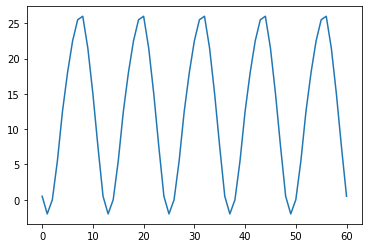

In [814]:
macro_features['TempKr'].plot()

In [815]:
macro_features.loc[60,'TempKr'] = -2  #As TempKr is avg temperature same for different months assigning previous same month value

As EUTourAccommodation, M2 columns has a periodic trend. Missing values are updated with added average percent change for that month

In [816]:
for i in (macro_features[macro_features['EUTourAccommodation']==0].index): #Looping for rows where value is 0
    month = (macro_features.loc[macro_features.index.get_loc(i),'month'])  #Checking month for that row
    avgchange = macro_features[macro_features['month']==month]['EUTourAccommodation'].pct_change()[:-1].mean() #Calculating mean percent change for that month throughout year and updating missing value by adding previous value with avg percent change
    macro_features.loc[macro_features.index.get_loc(i),'EUTourAccommodation'] = macro_features.loc[macro_features.index.get_loc(i)-12,'EUTourAccommodation'] + (macro_features.loc[macro_features.index.get_loc(i)-12,'EUTourAccommodation'] * avgchange)
for i in (macro_features[macro_features['M2']==0].index): #Looping for rows where value is 0
    month = (macro_features.loc[macro_features.index.get_loc(i),'month'])  #Checking month for that row
    avgchange = macro_features[macro_features['month']==month]['M2'].pct_change()[:-1].mean() #Calculating mean percent change for that month throughout year and updating missing value by adding previous value with avg percent change
    macro_features.loc[macro_features.index.get_loc(i),'M2'] = macro_features.loc[macro_features.index.get_loc(i)-12,'M2'] + (macro_features.loc[macro_features.index.get_loc(i)-12,'M2'] * avgchange)    

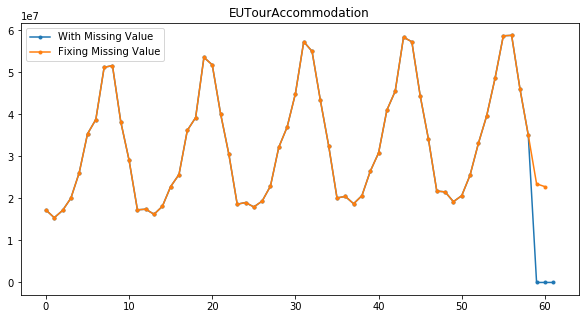

In [817]:
plt.figure(figsize=(10,5))
Material[1]['EUTourAccommodation'].plot(marker='.',label='With Missing Value',title='EUTourAccommodation')
macro_features['EUTourAccommodation'].plot(marker='.',label='Fixing Missing Value')
plt.legend(loc="upper left")

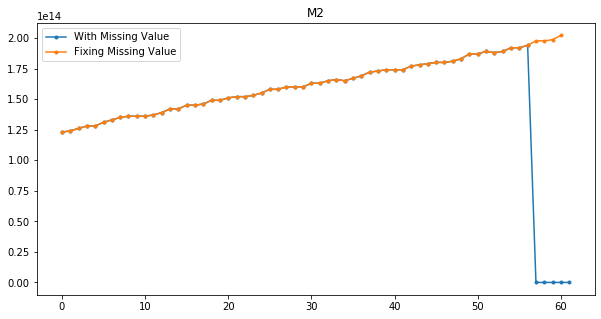

In [818]:
plt.figure(figsize=(10,5))
Material[1]['M2'].plot(marker='.',label='With Missing Value',title='M2')
macro_features['M2'].plot(marker='.',label='Fixing Missing Value')
plt.legend(loc="upper left")

In [819]:
macro_features['CHNVisitorsKr'].replace(0,np.nan,inplace=True) #Replace 0 with Nan
macro_features['CHNFemaleVisitorKr'].replace(0,np.nan,inplace=True)

In [820]:
macro_features['CHNVisitorsKr'].ffill(inplace=True) #Applying forward fill to update Nan values with previous value
macro_features['CHNFemaleVisitorKr'].ffill(inplace=True)

In [821]:
macro_features.tail(5) #Macro-economic features are ready to use

,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU,month
56,7.0629,1.940000e+14,108.9,98.5,578112.0,345329.0,1853600,2427634,26.0,169.14,25,29.0,5.879749e+07,7.8661,8
57,7.1137,1.976454e+14,109.8,98.3,541350.0,330432.0,1708100,2049830,21.5,167.75,20,24.0,4.610020e+07,7.7917,9
58,7.0961,1.976449e+14,110.8,98.2,567695.0,348980.0,1788400,2153847,15.0,166.24,13,19.0,3.506486e+07,7.8505,10
59,7.0199,1.986248e+14,111.2,98.1,505369.0,310161.0,1627000,2090192,7.5,168.03,5,13.0,2.347036e+07,7.7477,11
60,7.0137,2.021396e+14,111.2,98.1,505369.0,310161.0,1883000,2342314,-2.0,165.88,-2,7.0,2.279709e+07,7.8072,12


In [822]:
Material[1].drop(Material[1].index[-1],inplace=True) #Removing last row and adding common fixed macro-economic features to all item dataframes
Material[2].drop(Material[2].index[-1],inplace=True)
Material[3].drop(Material[3].index[-1],inplace=True)
Material[4].drop(Material[4].index[-1],inplace=True)
Material[1].reset_index(inplace=True,drop=True)
Material[2].reset_index(inplace=True,drop=True)
Material[3].reset_index(inplace=True,drop=True)
Material[4].reset_index(inplace=True,drop=True)
Material[1].iloc[:,6:] = macro_features
Material[2].iloc[:,6:] = macro_features
Material[3].iloc[:,6:] = macro_features
Material[4].iloc[:,6:] = macro_features
Material[1].index = pd.DatetimeIndex(Material[1].Date)
Material[2].index = pd.DatetimeIndex(Material[2].Date)
Material[3].index = pd.DatetimeIndex(Material[3].Date)
Material[4].index = pd.DatetimeIndex(Material[4].Date)

# Exploratory Data Analysis

In [823]:
def monthlygraph(month,item): #Function to plot item wise monthly total sales/orders graph throughout all years
    Material[item][Material[item]['month']==month][['Sell-In','Sell-Thru','Orders']].plot.bar(title=Material[item]['Material'][0],figsize=(15,7))

In [824]:
widgets.interact(monthlygraph,month=range(1,13) ,item=[ 1, 2, 3, 4]);

interactive(children=(Dropdown(description='month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1),…

In [825]:
def Allfeatures(item): #Function to plot Sell-In vs All features with correlation value item wise 
    temp = Material[item].copy()
    temp.drop(temp[temp['Sell-In']==0].index,inplace=True)
    fig = plt.figure(figsize=(25,30))
    for j,i in enumerate(temp.columns[3:-1],start=1):
        ax1 = fig.add_subplot(6,3,j)
        ax2 = ax1.twinx()
        ax1.plot(temp.index,temp['Sell-In'],'g-',label='Sell-In')
        ax2.plot(temp.index,temp[i],'b-',label=i)
        ax1.get_xaxis().set_ticks([temp.index[0],temp.index[int(len(temp)/2)],temp.index[-1]])
        ax1.set_title(temp['Material'][0]+' Sell-In Vs '+i+'  (Corr - '+str(round(temp.corr()['Sell-In'][i],2))+')')
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper center")

In [826]:
widgets.interact(Allfeatures ,item=[ 1, 2, 3, 4]);

interactive(children=(Dropdown(description='item', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=('w…

In [827]:
def seasonal(item):  #Function to get seasonality plot for Sell-in
    result = seasonal_decompose(Material[item]['Sell-In'], model='additive', period=12)
    result.plot()

In [828]:
widgets.interact(seasonal ,item=[ 1, 2, 3, 4]);

interactive(children=(Dropdown(description='item', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=('w…

In [829]:
Material[2].drop(Material[2][Material[2]['Sell-In']==0].index,inplace=True) #Removing 0 value rows from short data materials
Material[3].drop(Material[4][Material[3]['Sell-In']==0].index,inplace=True)

In [830]:
def heatmap(item): #Function for plotting correlation heat meap for different item
    fig = plt.figure(figsize=(25,10))
    dataplot = sb.heatmap(Material[item].corr(), cmap="YlGnBu", annot=True)
    plt.title(Material[item]['Material'][0])
    plt.show()

In [831]:
widgets.interact(heatmap ,item=[ 1, 2, 3, 4]);

interactive(children=(Dropdown(description='item', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=('w…

# Feature Engineering

Extracting important features for different materials.

In [832]:
data = Material[1].iloc[:,2:-1].copy()   #for 1st Material 1G5Y62

In [833]:
X = data.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) 

In [834]:
pca = PCA() #Applying Principle Component Analysis
X_pca = pca.fit(X_std)

The number of components needed can be determined by looking at the cumulative explained variance ratio as a function of the number of components as shown in the below graph.

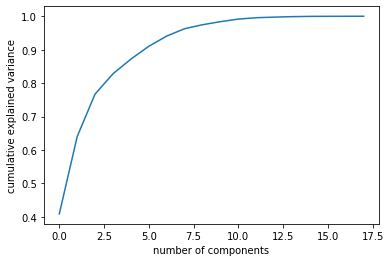

In [835]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

According to the above curve we need 11 components to describe close to 100% of the variance. Which means we can reduce our data dimension to 11 from 18 without much loss of the data.

In [836]:
pca = PCA(n_components = 0.99) #Similarly we can get no. of features required from this function
X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions
print(pca.n_components_)

11


Dimensionality Reduction: Now we know that we need 11 components only, so we can apply PCA with 11 components to get the reduced dataset

In [837]:
num_components = 11
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std)

In [838]:
pd.DataFrame(pca.components_, columns = data.columns)

,Sell-In,Sell-Thru,Stock,Orders,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU
0,0.244302,0.317126,0.131266,0.200499,0.280505,0.362070,0.347712,-0.342687,-0.079686,-0.064967,0.166612,0.305416,0.061081,-0.267910,0.056875,0.068640,0.122603,0.322657
1,-0.054746,-0.015942,0.263131,0.079306,-0.017286,0.040274,0.076372,-0.027782,-0.151523,-0.141100,0.018152,0.090674,-0.473222,-0.045674,-0.469943,-0.471512,-0.438268,-0.000884
2,-0.025564,-0.082083,0.098700,-0.037543,-0.134225,-0.033296,-0.095603,0.060140,-0.584457,-0.596056,-0.425909,0.101173,0.100452,-0.049964,0.103547,0.099308,0.116294,0.119894
3,0.195450,0.180803,0.475204,0.269776,-0.498702,0.046460,0.069137,0.177333,-0.054026,-0.057360,0.350823,-0.005891,0.072485,0.413915,0.094533,0.054389,0.097310,-0.127120
4,-0.503562,-0.192199,0.132195,0.647262,-0.068263,-0.058006,-0.157050,0.040982,0.159829,0.159841,-0.157498,0.340501,0.020595,-0.148511,0.030927,0.038264,0.109697,0.099591
5,-0.227018,0.235421,-0.605845,0.408793,0.151312,0.048397,0.089795,-0.007642,-0.252002,-0.238339,0.244565,-0.116983,-0.043584,0.277220,-0.008929,-0.047490,-0.026294,-0.223464
6,0.642027,-0.224332,-0.011567,0.491432,0.216039,-0.070046,-0.031991,-0.043753,0.055484,0.058458,-0.391699,-0.203230,-0.008625,0.108009,-0.042062,0.015751,-0.077587,-0.142536
7,0.229137,-0.111564,-0.199878,0.185317,-0.243168,-0.108745,-0.143606,0.328850,-0.085594,-0.069789,0.389594,-0.228243,0.014327,-0.612670,0.032585,-0.030245,-0.090844,0.243231
8,-0.245494,0.512220,0.255913,0.103688,-0.020590,0.037195,0.119030,-0.008583,0.045855,0.030207,-0.303037,-0.553620,0.053501,-0.336063,0.085859,0.033121,-0.092698,-0.225536
9,-0.237360,-0.416873,0.203589,0.064818,0.143297,0.059887,0.075902,-0.309954,-0.066614,-0.068111,0.201225,-0.504858,0.129357,0.221479,0.132866,0.051704,-0.201330,0.408874


In [839]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = data.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['M2',
 'TempKr',
 'CHNFemaleVisitorKr',
 'EXCHUS',
 'Orders',
 'Stock',
 'Sell-In',
 'EXCHKR',
 'TourDepart',
 'TourDepart',
 'EXCHEU']

In [840]:
data1 = data[['Sell-In','M2', 'TempKr', 'CHNFemaleVisitorKr']]

In [841]:
nobs = 12 
df_train, df_test = data1[0:-nobs], data1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(49, 4)
(12, 4)


In [842]:
def adf(data,  variable=None, signif=0.05, verbose=False): #Adfuler test to check stationary of time series
    r = adfuller(data, autolag='AIC')
    output = {'test_statistic':np.round(r[0], 4), 'pvalue':np.round(r[1], 4), 'n_lags':np.round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']    
    for key,val in r[4].items():
        print(' Critical value', key, np.round(val, 3))
    if p_value <= signif:
        print("p-Value = ", p_value, ". P value is less than critical value. Reject Null H. Series is Stationary.")
    else:
        print("p-Value = ", p_value, ".  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary")

In [843]:
for name, column in df_train.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -3.61
 Critical value 5% -2.939
 Critical value 10% -2.608
p-Value =  1.0 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Critical value 1% -3.616
 Critical value 5% -2.941
 Critical value 10% -2.609
p-Value =  0.9941 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Critical value 1% -3.621
 Critical value 5% -2.944
 Critical value 10% -2.61
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.578
 Critical value 5% -2.925
 Critical value 10% -2.601
p-Value =  0.1316 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary




As the series are non stationary. Applyicing diffrencing 

In [844]:
# 1st order differencing
df_differenced = df_train.diff().dropna()

#2nd order differencing
# df_differenced = df_differenced.diff().dropna()

In [845]:
for name, column in df_differenced.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -3.585
 Critical value 5% -2.928
 Critical value 10% -2.602
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.61
 Critical value 5% -2.939
 Critical value 10% -2.608
p-Value =  0.0002 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.621
 Critical value 5% -2.944
 Critical value 10% -2.61
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.578
 Critical value 5% -2.925
 Critical value 10% -2.601
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.




After applying differencing once, the ADF test shows that the variables are stationary.

Text(0.5, 1.0, 'Sell-In - 1st order differenced')

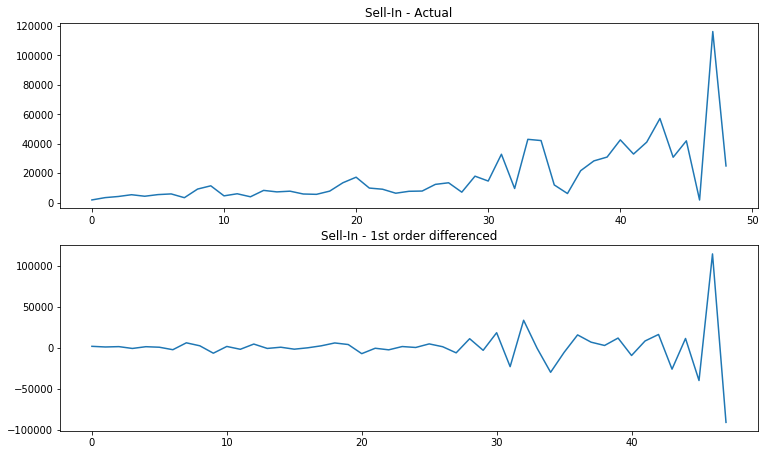

In [846]:
fig, ax = plt.subplots(2,1, figsize=(12.5,7.5))  #plotting grapgh to check stationary

df_train.reset_index()['Sell-In'].plot(ax=ax[0])
df_differenced.reset_index()['Sell-In'].plot(ax=ax[1])
ax[0].set_title('Sell-In - Actual')
ax[1].set_title('Sell-In - 1st order differenced')

The Granger Causality Test is a statistical test that measures if a time series is useful in forecasting another. Specifically, it identifies if a variable’s lag is repeated on another time series.

In [847]:
from statsmodels.tsa.stattools import grangercausalitytests 
maxlag=12
test = 'ssr_chi2test'

df = pd.DataFrame(np.zeros((len(df_differenced.columns), len(df_differenced.columns))), columns=df_differenced.columns, index=df_differenced.columns)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(df_differenced[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in df_differenced.columns]
df.index = [var + '_y' for var in df_differenced.columns]

grangerdf = df
grangerdf

C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  'rank is %d' % (J, J_)

,Sell-In_x,M2_x,TempKr_x,CHNFemaleVisitorKr_x
Sell-In_y,1.0000,0.1413,0.0002,0.3043
M2_y,0.0743,0.9998,0.0000,0.0037
TempKr_y,0.0402,0.0000,0.0000,0.0000
CHNFemaleVisitorKr_y,0.1808,0.0014,0.0000,1.0000


 From the table we can see that TempKr has critical value of less than 0.05, meaning the hypothesis fail to assume they are not a lag of each other, which means, we can purport they may be useful. M2,CHNFemaleVisiorKr however, does not seem to move in correlation with Sell-In, but since it is correlated with other indicators, we will retain them inside the model.

Co-integration here connotes a statistically significant relationship in between two or more variables in the long run. In other words, in the long run, the average of the variables moves closely with each other.

In [848]:
alpha = 0.05                                #Co-Integration test
out = coint_johansen(df_differenced,-1,5)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d[str(1-alpha)]]
def adjust(val, length= 6): 
    return str(val).ljust(length)

# # Summary
col_name =[]
trace_value = []
cvt_value = []
indicator = []
for col, trace, cvt in zip(df_differenced.columns, traces, cvts):
    col_name.append(col)
    trace_value.append(np.round(trace, 2))
    cvt_value.append(cvt)
    indicator.append(trace> cvt)
    
d = {'Name':col_name, 'Test Stat' : trace_value, 'Critical Value (95%)': cvt_value, 'Significance': indicator} 
cj = pd.DataFrame(d)
cj[['Name', 'Test Stat', 'Critical Value (95%)', 'Significance']]

,Name,Test Stat,Critical Value (95%),Significance
0,Sell-In,113.68,40.1749,True
1,M2,31.67,24.2761,True
2,TempKr,7.15,12.3212,False
3,CHNFemaleVisitorKr,0.26,4.1296,False


Here we can purport that Sell-In has significant relationship with other macroeconomic indicators, but not those indicators themselves among the rest. This result is acceptable, since we only concern with the "status" of Sell-In as it moves along with these macroeconomic measures.

Based on above test results, we finalize are input variable for Material 1 - 1G5Y62

# Model Development and Delivery

In [849]:
model = VAR(df_differenced) #initialiing VAR model
for i in range(1,12):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  99.35924929262393
BIC :  100.14654614441544
FPE :  1.4209460260026475e+43
HQIC:  99.65551438681229 

Lag Order = 2
AIC :  98.15114753795517
BIC :  99.58225819607708
FPE :  4.318971655685146e+42
HQIC:  98.68725016777638 

Lag Order = 3
AIC :  98.19736794232867
BIC :  100.28506681939659
FPE :  4.742248339405225e+42
HQIC:  98.9756411224019 

Lag Order = 4
AIC :  97.58581922498132
BIC :  100.34320320467317
FPE :  2.8476218888752966e+42
HQIC:  98.60839013376281 

Lag Order = 5
AIC :  97.4323993751627
BIC :  100.87288332209897
FPE :  2.9689585811075806e+42
HQIC:  98.70114352582154 

Lag Order = 6
AIC :  95.21572368388733
BIC :  99.35303229884774
FPE :  4.6355145670853516e+41
HQIC:  96.7322109243889 

Lag Order = 7
AIC :  94.61272064230745
BIC :  99.4608757578611
FPE :  4.965676853751295e+41
HQIC:  96.3781514333189 

Lag Order = 8
AIC :  92.64879753280914
BIC :  98.22209973138514
FPE :  2.775985691925004e+41
HQIC:  94.66392762316651 

Lag Order = 9
AIC :  73.4558919337308

C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [850]:
#Checking with different lags to get best input

In [851]:
model_fitted = model.fit(7) #With lag 7 it gets best result
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Jan, 2022
Time:                     23:36:13
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    99.4609
Nobs:                     41.0000    HQIC:                   96.3782
Log likelihood:          -2056.27    FPE:                4.96568e+41
AIC:                      94.6127    Det(Omega_mle):     5.84415e+40
--------------------------------------------------------------------
Results for equation Sell-In
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                     28539.593603     34622.215497            0.824           0.410
L1.Sell-In                   -1.183868         0.275213           -4.302           0.000
L1.M2                     

In [852]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:       
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [853]:
lag_order = model_fitted.k_ar   #getting input lag
print(lag_order) 
forecast_input = df_differenced.values[-lag_order:]  #input for mode;
fc = model_fitted.forecast(y=forecast_input, steps=nobs)  #forecast result
df_forecast = pd.DataFrame(fc, index=data1.index[-nobs:], columns=data1.columns + '_1d')  #Reverting result differencing
df_results=invert_transformation(df_train,df_forecast,second_diff=False)
forecast = df_results['Sell-In_forecast'].values
actual = df_test['Sell-In']
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
wape = (sum(abs(df_test['Sell-In']-df_results['Sell-In_forecast'])) / sum(abs(df_test['Sell-In']))) *100 #WAPE
print('Mean Absolute Percentage Error: ',mape)
print('WAPE                          :',wape)

7
Mean Absolute Percentage Error:  1.1153124102486407
WAPE                          : 59.86639783399952


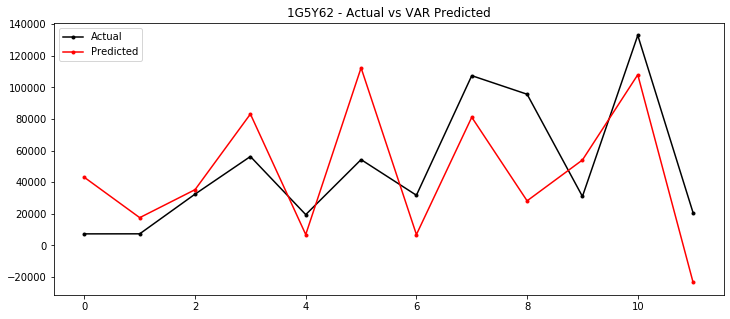

In [854]:
fig, ax = plt.subplots(figsize=(12, 5))

df_test.reset_index()['Sell-In'].plot(color='k', label='Actual',marker='.')
df_results.reset_index()['Sell-In_forecast'].plot(color='r', label='Predicted',marker='.')
ax.set_title('1G5Y62 - Actual vs VAR Predicted')
ax.legend()

In [855]:
Results = pd.DataFrame()
Results['Actual'] = df_test['Sell-In'].values
Results['VAR Forecast'] = df_results['Sell-In_forecast'].values

In [856]:
Results

,Actual,VAR Forecast
0,7295,43046.129170
1,7322,17550.700847
2,32442,35261.795310
3,56235,83103.521833
4,19469,6871.686008
5,54271,112338.140632
6,31724,6858.114065
7,107381,81074.829776
8,95631,28195.187800
9,30972,54025.155208


In [857]:
pdata = data.copy()

In [858]:
pdata['y']  = pdata['Sell-In']
pdata['ds'] = pdata.index

In [859]:
m = Prophet(seasonality_mode='multiplicative', #initializing prophet model
            growth='linear',
           yearly_seasonality=True,
            mcmc_samples=0,
            )

In [860]:
pdata['month'] = pd.DatetimeIndex(pdata.index).month #getting month and year as a feature
pdata['year'] = pd.DatetimeIndex(pdata.index).year

In [861]:
pdata1 = pdata[['y','month','year','ds']]

In [862]:
nobs = 12 ## we use the values on the last 12 months as the test set
df_train, df_test = pdata1[0:-nobs], pdata1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(49, 4)
(12, 4)


In [863]:
cols = np.array(df_train.columns)  
modified_array = np.delete(cols, np.where(cols == 'y'))
modified_array2 = np.delete(modified_array, np.where(modified_array == 'ds'))
alldf_regressor = modified_array2

In [864]:
m.add_regressor('month', prior_scale=0.5, mode='multiplicative')  #adding month,year as regressor as we will have test data also for this feature
m.add_regressor('year', prior_scale=0.5, mode='multiplicative')

In [865]:
m.fit(df_train) #fitting model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [866]:
future2 = df_test[['ds','month','year']].reset_index() 

In [867]:
forecast = m.predict(future2) #forecast

In [868]:
result = pd.DataFrame()

In [869]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,month,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-01,41701.519942,25925.256019,44775.686721,41701.472462,41701.541091,0.536896,0.536896,0.536896,-0.024798,...,0.561694,0.561694,0.561694,-0.688178,-0.688178,-0.688178,0.0,0.0,0.0,35392.846021
1,2019-02-01,42761.899868,38791.446220,56296.681788,42761.710413,42762.014365,0.541314,0.541314,0.541314,-0.020379,...,0.561694,0.561694,0.561694,-0.416808,-0.416808,-0.416808,0.0,0.0,0.0,48086.033111
2,2019-03-01,43719.662381,19577.051357,37595.527920,43719.306692,43719.908780,0.545733,0.545733,0.545733,-0.015961,...,0.561694,0.561694,0.561694,-0.901491,-0.901491,-0.901491,0.0,0.0,0.0,28166.056044
3,2019-04-01,44780.042307,68811.195873,86874.964685,44779.476470,44780.430415,0.550151,0.550151,0.550151,-0.011542,...,0.561694,0.561694,0.561694,0.182733,0.182733,0.182733,0.0,0.0,0.0,77598.618231
4,2019-05-01,45806.216429,45360.959440,62832.690722,45805.441506,45806.780528,0.554570,0.554570,0.554570,-0.007124,...,0.561694,0.561694,0.561694,-0.369732,-0.369732,-0.369732,0.0,0.0,0.0,54272.949080
5,2019-06-01,46866.596354,71983.237958,90694.045462,46865.499085,46867.394322,0.558988,0.558988,0.558988,-0.002705,...,0.561694,0.561694,0.561694,0.173826,0.173826,0.173826,0.0,0.0,0.0,81211.109661
6,2019-07-01,47892.770476,85790.649582,102927.371183,47891.392972,47893.853090,0.563407,0.563407,0.563407,0.001713,...,0.561694,0.561694,0.561694,0.410725,0.410725,0.410725,0.0,0.0,0.0,94546.646976
7,2019-08-01,48953.150402,40029.013154,57435.771959,48951.434397,48954.459902,0.567825,0.567825,0.567825,0.006132,...,0.561694,0.561694,0.561694,-0.571885,-0.571885,-0.571885,0.0,0.0,0.0,48754.431044
8,2019-09-01,50013.530328,53988.795264,72956.345444,50011.430355,50015.173719,0.572244,0.572244,0.572244,0.010550,...,0.561694,0.561694,0.561694,-0.312507,-0.312507,-0.312507,0.0,0.0,0.0,63003.907216
9,2019-10-01,51039.704449,-33251.658116,-16142.327898,51037.185666,51041.679083,0.576662,0.576662,0.576662,0.014969,...,0.561694,0.561694,0.561694,-2.051872,-2.051872,-2.051872,0.0,0.0,0.0,-24254.543659


In [870]:
result['y_prophet'] = forecast['yhat'].values
result['y'] = df_test['y'].values

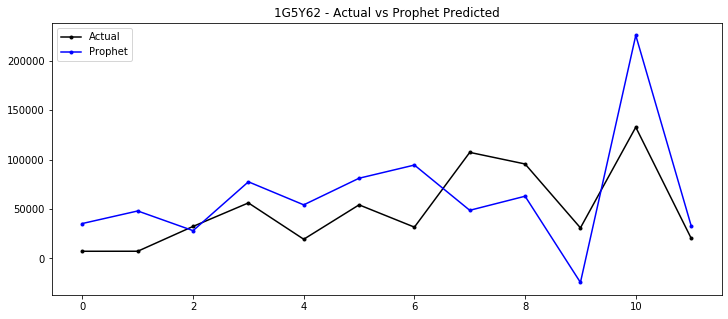

In [871]:
fig, ax = plt.subplots(figsize=(12, 5))
result['y'].plot(color='k', label='Actual',marker='.')
result['y_prophet'].plot(color='b', label='Prophet',marker='.')
ax.set_title('1G5Y62 - Actual vs Prophet Predicted')
ax.legend()

In [872]:
wape = (sum(abs(result['y']-result['y_prophet'])) / sum(abs(result['y']))) *100
wape

79.03527417145328

In [873]:
Results['Prophet Forecast'] = result['y_prophet'].values

In [874]:
Results

,Actual,VAR Forecast,Prophet Forecast
0,7295,43046.129170,35392.846021
1,7322,17550.700847,48086.033111
2,32442,35261.795310,28166.056044
3,56235,83103.521833,77598.618231
4,19469,6871.686008,54272.949080
5,54271,112338.140632,81211.109661
6,31724,6858.114065,94546.646976
7,107381,81074.829776,48754.431044
8,95631,28195.187800,63003.907216
9,30972,54025.155208,-24254.543659


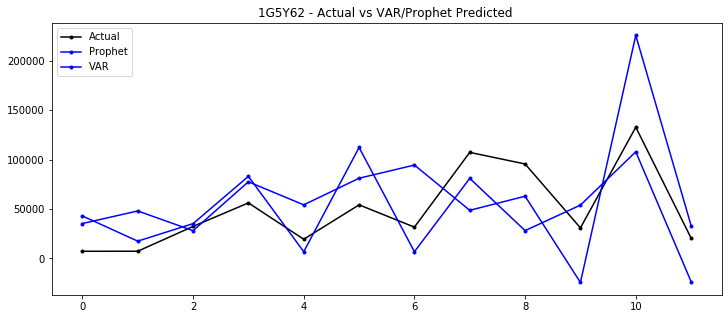

In [875]:
fig, ax = plt.subplots(figsize=(12, 5))

Results['Actual'].plot(color='k', label='Actual',marker='.')
Results['Prophet Forecast'].plot(color='b', label='Prophet',marker='.')
Results['VAR Forecast'].plot(color='b', label='VAR',marker='.')
ax.set_title('1G5Y62 - Actual vs VAR/Prophet Predicted ')
ax.legend()

In [876]:
Results.index = df_test['ds']

In [877]:
Results.to_excel('1G5Y62_Reults.xlsx')

Similarly we will feature engineer and forecast for other three Materials

Material 2 - RY9801

In [878]:
data = Material[2].iloc[:,2:-1].copy() 

In [879]:
X = data.values 
sc = StandardScaler() 
X_std = sc.fit_transform(X) 

In [880]:
pca = PCA() 
X_pca = pca.fit(X_std)

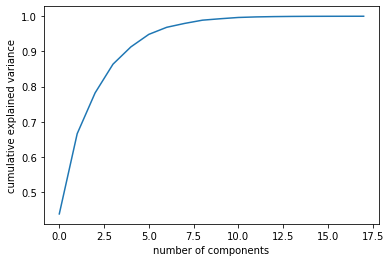

In [881]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [882]:
pca = PCA(n_components = 0.99) 
X_pca = pca.fit_transform(X_std) 
print(pca.n_components_)

10


Dimensionality Reduction: Now we know that we need 11 components only, so we can apply PCA with 11 components to get the reduced dataset

In [883]:
num_components = 10
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std)

In [884]:
pd.DataFrame(pca.components_, columns = data.columns)

,Sell-In,Sell-Thru,Stock,Orders,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU
0,-0.220528,-0.286220,-0.284046,-0.150972,-0.295794,-0.328310,-0.293097,0.313484,-0.341997,-0.349504,-0.232385,0.111632,-0.137902,-0.054152,-0.134458,-0.148690,-0.137077,-0.002064
1,-0.120287,-0.206673,0.023147,-0.104499,0.004391,-0.151348,-0.200726,0.169407,0.035247,0.022923,-0.053633,-0.077315,0.444879,-0.114185,0.435462,0.443013,0.429982,0.217020
2,0.163779,0.112680,-0.021194,0.109589,-0.337943,-0.083657,-0.160732,0.059521,-0.037732,-0.046001,0.262312,0.136568,0.113492,0.570213,0.175476,0.063520,0.139782,-0.560404
3,0.235924,0.160188,0.105887,0.530573,0.115898,-0.010417,-0.159498,0.051729,-0.110077,-0.076571,-0.218475,0.678784,0.003367,-0.128090,0.012001,0.026193,0.113952,0.166164
4,-0.625072,-0.255829,0.504118,0.381105,-0.113024,-0.004153,0.106161,-0.110946,0.003694,-0.010540,-0.094871,-0.030237,-0.014951,0.297527,-0.018350,-0.034268,-0.046043,0.075322
5,0.137641,-0.077367,-0.005000,-0.413157,-0.039963,0.115635,0.238285,-0.323635,-0.054994,-0.007993,-0.643820,0.205150,0.020610,0.379024,-0.003759,0.075918,0.131675,0.031284
6,0.108761,0.198996,-0.296331,0.500823,-0.061806,0.105093,0.053748,-0.082158,-0.231519,-0.175908,-0.380753,-0.567094,0.098778,0.024967,0.140384,0.047811,-0.037844,-0.022664
7,0.185954,-0.147406,0.516015,-0.061979,0.055329,0.000461,0.009035,0.130558,-0.028447,-0.089358,-0.286504,-0.107413,0.042969,-0.418757,0.013807,0.047370,-0.070185,-0.605318
8,0.529647,-0.071329,0.381015,0.022321,-0.223114,-0.313469,-0.114519,0.192866,0.167433,0.038481,-0.049583,-0.285934,-0.110586,0.224056,-0.119941,-0.106505,-0.014004,0.410212
9,0.097372,-0.557675,-0.376834,0.292432,0.158520,-0.186393,0.006111,-0.054590,0.493658,0.227710,-0.135726,0.020607,0.017696,0.030608,-0.165280,-0.030959,0.036635,-0.209391


In [885]:
n_pcs= pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = data.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['CHNFemaleVisitorKr',
 'TempKr',
 'EXCHKR',
 'TourDepart',
 'Sell-In',
 'KrTourReceipt',
 'TourDepart',
 'EXCHEU',
 'Sell-In',
 'Sell-Thru']

In [886]:
data1 = data[['Sell-In','CHNVisitorsKr', 'KrTourReceipt']]

In [887]:
nobs = 6
df_train, df_test = data1[0:-nobs], data1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(17, 3)
(6, 3)


In [888]:
def adf(data,  variable=None, signif=0.05, verbose=False): #Adfuler test to check stationary of time series
    r = adfuller(data, autolag='AIC')
    output = {'test_statistic':np.round(r[0], 4), 'pvalue':np.round(r[1], 4), 'n_lags':np.round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']    
    for key,val in r[4].items():
        print(' Critical value', key, np.round(val, 3))
    if p_value <= signif:
        print("p-Value = ", p_value, ". P value is less than critical value. Reject Null H. Series is Stationary.")
    else:
        print("p-Value = ", p_value, ".  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary")

In [889]:
for name, column in df_train.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -3.964
 Critical value 5% -3.085
 Critical value 10% -2.682
p-Value =  0.582 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Critical value 1% -4.332
 Critical value 5% -3.233
 Critical value 10% -2.749
p-Value =  0.9532 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Critical value 1% -3.924
 Critical value 5% -3.068
 Critical value 10% -2.674
p-Value =  0.0942 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary




As the series are non stationary. Applyicing diffrencing 

In [890]:
# 1st order differencing
df_differenced = df_train.diff().dropna()

#2nd order differencing
# df_differenced = df_differenced.diff().dropna()

In [891]:
for name, column in df_differenced.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -4.473
 Critical value 5% -3.29
 Critical value 10% -2.772
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -4.332
 Critical value 5% -3.233
 Critical value 10% -2.749
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -4.138
 Critical value 5% -3.155
 Critical value 10% -2.714
p-Value =  0.0062 . P value is less than critical value. Reject Null H. Series is Stationary.




After applying differencing once, the ADF test shows that the variables are stationary.

Text(0.5, 1.0, 'Sell-In - 1st order differenced')

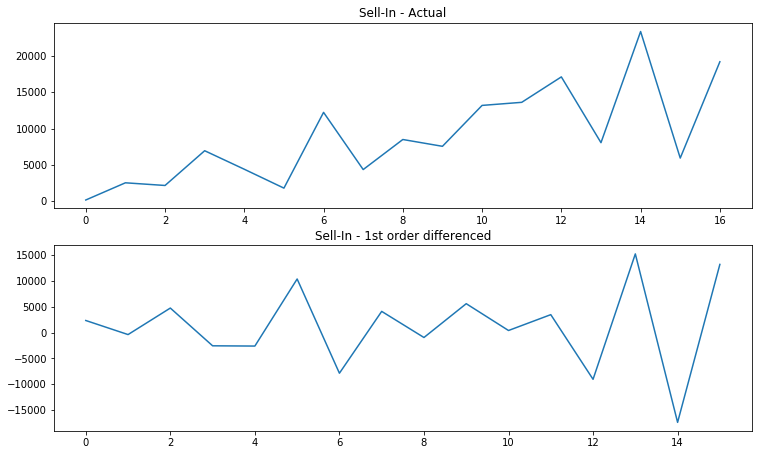

In [892]:
fig, ax = plt.subplots(2,1, figsize=(12.5,7.5))  #plotting grapgh to check stationary

df_train.reset_index()['Sell-In'].plot(ax=ax[0])
df_differenced.reset_index()['Sell-In'].plot(ax=ax[1])
ax[0].set_title('Sell-In - Actual')
ax[1].set_title('Sell-In - 1st order differenced')

In [893]:
from statsmodels.tsa.stattools import grangercausalitytests 
maxlag=4
test = 'ssr_chi2test'

df = pd.DataFrame(np.zeros((len(df_differenced.columns), len(df_differenced.columns))), columns=df_differenced.columns, index=df_differenced.columns)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(df_differenced[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in df_differenced.columns]
df.index = [var + '_y' for var in df_differenced.columns]

grangerdf = df
grangerdf

,Sell-In_x,CHNVisitorsKr_x,KrTourReceipt_x
Sell-In_y,1.0000,0.0000,0.0000
CHNVisitorsKr_y,0.1423,1.0000,0.3533
KrTourReceipt_y,0.2742,0.0296,1.0000


In [894]:
alpha = 0.05                                #Co-Integration test
out = coint_johansen(df_differenced,-1,5)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d[str(1-alpha)]]
def adjust(val, length= 6): 
    return str(val).ljust(length)

# # Summary
col_name =[]
trace_value = []
cvt_value = []
indicator = []
for col, trace, cvt in zip(df_differenced.columns, traces, cvts):
    col_name.append(col)
    trace_value.append(np.round(trace, 2))
    cvt_value.append(cvt)
    indicator.append(trace> cvt)
    
d = {'Name':col_name, 'Test Stat' : trace_value, 'Critical Value (95%)': cvt_value, 'Significance': indicator} 
cj = pd.DataFrame(d)
cj[['Name', 'Test Stat', 'Critical Value (95%)', 'Significance']]

,Name,Test Stat,Critical Value (95%),Significance
0,Sell-In,45.53,24.2761,True
1,CHNVisitorsKr,17.00,12.3212,True
2,KrTourReceipt,0.52,4.1296,False


In [895]:
model = VAR(df_differenced) #initialiing VAR model
for i in range(1,12):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  63.72416017709305
BIC :  64.29060033797481
FPE :  4.9233726092971946e+27
HQIC:  63.718126405815276 

Lag Order = 2
AIC :  63.98016153833409
BIC :  64.93874753275698
FPE :  8.216964786533889e+27
HQIC:  63.89142688216618 

Lag Order = 3
AIC :  58.98872957642436
BIC :  60.292458862874064
FPE :  1.8529488165376775e+26
HQIC:  58.72075450603103 

Lag Order = 4
AIC :  -122.37061701483248
BIC :  -120.79467040302147
FPE :  -1.682759988082827e-52
HQIC:  -122.95408890795785 

Lag Order = 5
AIC :  -124.58535246288957
BIC :  -122.84908218158759
FPE :  -1.9963826705279152e-56
HQIC:  -125.67982766646465 

Lag Order = 6
AIC :  -128.84055007984057
BIC :  -127.11581504977451
FPE :  -4.1568985599721656e-60
HQIC:  -130.73258020401389 

Lag Order = 7
AIC :  -124.3456171630808
BIC :  -122.89930359594854
FPE :  -5.754230313273807e-60
HQIC:  -127.46675704315669 

Lag Order = 8
AIC :  -118.68251261407022
BIC :  -117.93774816082176
FPE :  -1.506652834977569e-59
HQIC:  -123.70564946244937 



C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [896]:
model_fitted = model.fit(7) 
model_fitted.summary()

C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1416: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Jan, 2022
Time:                     23:36:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -122.899
Nobs:                     9.00000    HQIC:                  -127.467
Log likelihood:           587.244    FPE:               -5.75423e-60
AIC:                     -124.346    Det(Omega_mle):    -1.40809e-61
--------------------------------------------------------------------
Results for equation Sell-In
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000002              NAN              NAN             NAN
L1.Sell-In               0.001369              NAN              NAN             NAN
L1.CHNVisitorsKr        -0.002527         0.00

In [897]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:       
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [898]:
lag_order = model_fitted.k_ar   #getting input lag
print(lag_order) 
forecast_input = df_differenced.values[-lag_order:]  #input for mode;
fc = model_fitted.forecast(y=forecast_input, steps=nobs)  #forecast result
df_forecast = pd.DataFrame(fc, index=data1.index[-nobs:], columns=data1.columns + '_1d')  #Reverting result differencing
df_results=invert_transformation(df_train,df_forecast,second_diff=False)
forecast = df_results['Sell-In_forecast'].values
actual = df_test['Sell-In']
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
wape = (sum(abs(df_test['Sell-In']-df_results['Sell-In_forecast'])) / sum(abs(df_test['Sell-In']))) *100 #WAPE
print('Mean Absolute Percentage Error: ',mape)
print('WAPE                          :',wape)

7
Mean Absolute Percentage Error:  0.4603225587192949
WAPE                          : 35.35608174606976


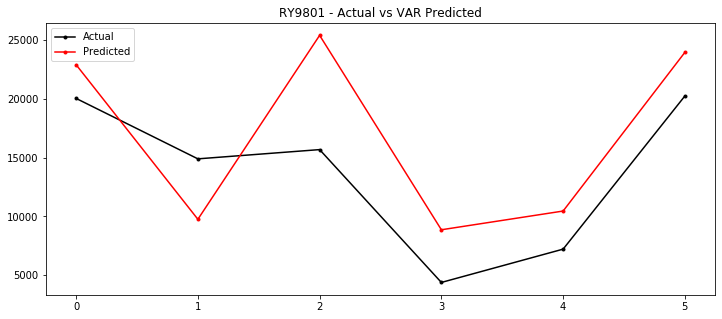

In [899]:
fig, ax = plt.subplots(figsize=(12, 5))

df_test.reset_index()['Sell-In'].plot(color='k', label='Actual',marker='.')
df_results.reset_index()['Sell-In_forecast'].plot(color='r', label='Predicted',marker='.')
ax.set_title('RY9801 - Actual vs VAR Predicted')
ax.legend()

In [900]:
Results1 = pd.DataFrame()
Results1['Actual'] = df_test['Sell-In'].values
Results1['VAR Forecast'] = df_results['Sell-In_forecast'].values

In [901]:
Results1

,Actual,VAR Forecast
0,20049,22914.854323
1,14906,9763.526030
2,15693,25416.601410
3,4387,8870.592189
4,7222,10464.383912
5,20254,23968.750804


In [902]:
pdata = data.copy()

In [903]:
pdata['y']  = pdata['Sell-In']
pdata['ds'] = pdata.index

In [904]:
m = Prophet(seasonality_mode='additive', #initializing prophet model
            growth='linear',
           yearly_seasonality=True,
            mcmc_samples=0,
            )

In [905]:
pdata['month'] = pd.DatetimeIndex(pdata.index).month #getting month and year as a feature
pdata['year'] = pd.DatetimeIndex(pdata.index).year

In [906]:
pdata1 = pdata[['y','month','year','ds']]

In [907]:
nobs = 6 ## we use the values on the last 12 months as the test set
df_train, df_test = pdata1[0:-nobs], pdata1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(17, 4)
(6, 4)


In [908]:
cols = np.array(df_train.columns)  
modified_array = np.delete(cols, np.where(cols == 'y'))
modified_array2 = np.delete(modified_array, np.where(modified_array == 'ds'))
alldf_regressor = modified_array2

In [909]:
m.add_regressor('month', prior_scale=0.5, mode='multiplicative')  #adding month,year as regressor as we will have test data also for this feature
m.add_regressor('year', prior_scale=0.5, mode='multiplicative')

In [910]:
m.fit(df_train) #fitting model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


In [911]:
future2 = df_test[['ds','month','year']].reset_index() 

In [912]:
forecast = m.predict(future2) #forecast

In [913]:
result = pd.DataFrame()

In [914]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_multiplicative,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,yhat
0,2019-07-01,17475.946116,16136.335303,16136.335820,17475.945895,17475.946361,-3031.230963,-3031.230963,-3031.230963,0.096797,...,0.096797,0.096797,0.096797,0.191021,0.191021,0.191021,-3031.230963,-3031.230963,-3031.230963,16136.335553
1,2019-08-01,17974.796313,20258.097199,20258.099030,17974.795397,17974.797182,1743.070068,1743.070068,1743.070068,0.030055,...,0.030055,0.030055,0.030055,0.191021,0.191021,0.191021,1743.070068,1743.070068,1743.070068,20258.098140
2,2019-09-01,18473.646510,11544.697321,11544.700969,18473.644582,18473.648363,-6251.201819,-6251.201819,-6251.201819,-0.036687,...,-0.036687,-0.036687,-0.036687,0.191021,0.191021,0.191021,-6251.201819,-6251.201819,-6251.201819,11544.699178
3,2019-10-01,18956.404765,21574.794504,21574.799996,18956.401665,18956.407785,4579.039559,4579.039559,4579.039559,-0.103429,...,-0.103429,-0.103429,-0.103429,0.191021,0.191021,0.191021,4579.039559,4579.039559,4579.039559,21574.797283
4,2019-11-01,19455.254961,10299.773047,10299.780431,19455.250349,19455.259260,-5844.750530,-5844.750530,-5844.750530,-0.170171,...,-0.170171,-0.170171,-0.170171,0.191021,0.191021,0.191021,-5844.750530,-5844.750530,-5844.750530,10299.776865
5,2019-12-01,19938.013216,22839.571741,22839.580712,19938.007021,19938.018777,7625.147581,7625.147581,7625.147581,-0.236913,...,-0.236913,-0.236913,-0.236913,0.191021,0.191021,0.191021,7625.147581,7625.147581,7625.147581,22839.576472


In [915]:
result['y_prophet'] = forecast['yhat'].values
result['y'] = df_test['y'].values

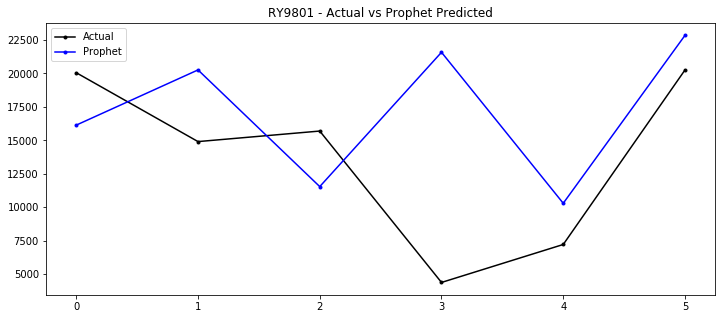

In [916]:
fig, ax = plt.subplots(figsize=(12, 5))
result['y'].plot(color='k', label='Actual',marker='.')
result['y_prophet'].plot(color='b', label='Prophet',marker='.')
ax.set_title('RY9801 - Actual vs Prophet Predicted')
ax.legend()

In [917]:
wape = (sum(abs(result['y']-result['y_prophet'])) / sum(abs(result['y']))) *100
wape

43.95076296461779

In [918]:
Results1['Prophet Forecast'] = result['y_prophet'].values

In [919]:
Results1

,Actual,VAR Forecast,Prophet Forecast
0,20049,22914.854323,16136.335553
1,14906,9763.526030,20258.098140
2,15693,25416.601410,11544.699178
3,4387,8870.592189,21574.797283
4,7222,10464.383912,10299.776865
5,20254,23968.750804,22839.576472


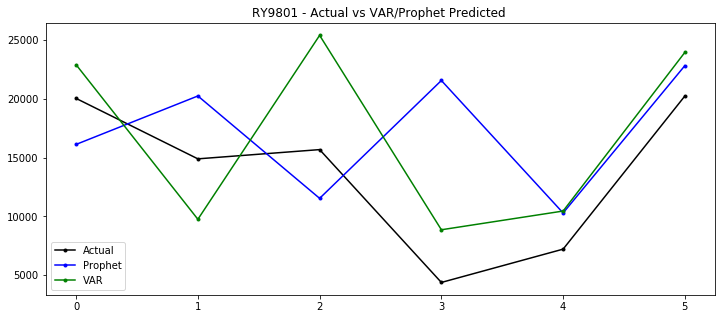

In [920]:
fig, ax = plt.subplots(figsize=(12, 5))

Results1['Actual'].plot(color='k', label='Actual',marker='.')
Results1['Prophet Forecast'].plot(color='b', label='Prophet',marker='.')
Results1['VAR Forecast'].plot(color='g', label='VAR',marker='.')
ax.set_title('RY9801 - Actual vs VAR/Prophet Predicted ')
ax.legend()

In [921]:
Results1.index = df_test['ds']

In [922]:
Results1

,Actual,VAR Forecast,Prophet Forecast
ds,,,
2019-07-01,20049,22914.854323,16136.335553
2019-08-01,14906,9763.526030,20258.098140
2019-09-01,15693,25416.601410,11544.699178
2019-10-01,4387,8870.592189,21574.797283
2019-11-01,7222,10464.383912,10299.776865
2019-12-01,20254,23968.750804,22839.576472


In [923]:
Results1.to_excel('RY9801_Reults.xlsx')

Material - 3 RYAN01

In [924]:
data = Material[3].iloc[:,2:-1].copy() 

In [925]:
X = data.values 
sc = StandardScaler() 
X_std = sc.fit_transform(X) 

In [926]:
pca = PCA() 
X_pca = pca.fit(X_std)

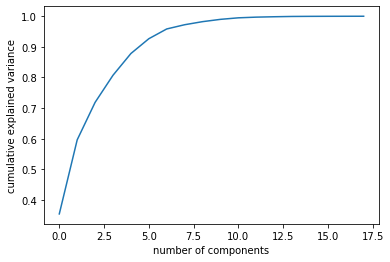

In [927]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [928]:
pca = PCA(n_components = 0.99) 
X_pca = pca.fit_transform(X_std) 
print(pca.n_components_)

11


In [929]:
num_components = 11
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std)

In [930]:
pd.DataFrame(pca.components_, columns = data.columns)

,Sell-In,Sell-Thru,Stock,Orders,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU
0,0.061991,0.211486,0.217302,0.056228,0.295515,0.380351,0.371770,-0.345333,0.383597,0.387201,0.309753,-0.070550,0.037872,0.039825,0.040177,0.040565,0.049975,-0.069371
1,-0.019012,-0.180993,0.072713,-0.117644,0.113726,-0.081528,-0.113561,0.014445,0.035427,0.028070,-0.063129,-0.110475,0.464073,0.009376,0.453016,0.471440,0.450778,0.225174
2,0.264895,0.304874,-0.296017,0.109011,-0.339363,-0.030203,-0.109219,0.169553,0.038242,0.023893,0.312133,0.068753,0.137290,0.398029,0.190909,0.075675,0.136335,-0.488255
3,-0.112454,0.144027,-0.396621,0.488319,0.169353,0.087703,-0.058898,0.174109,0.071942,0.086326,0.091794,0.505780,0.035396,-0.410003,0.046054,0.041872,0.105885,0.198453
4,0.354513,0.314987,-0.268792,-0.367369,0.003626,-0.037467,-0.019585,0.253749,0.093098,0.069849,0.130988,-0.442627,0.007812,-0.490410,-0.019367,-0.009506,-0.084132,0.164247
5,0.840804,-0.384751,0.106513,0.289758,0.032849,0.083688,0.044863,-0.065023,-0.087404,-0.035618,-0.107158,0.071286,-0.038021,-0.070496,-0.014144,-0.028451,0.044456,0.022672
6,0.182760,-0.005411,-0.150997,-0.676094,0.079854,0.020989,0.038695,-0.052185,0.106698,0.093221,-0.116970,0.627466,-0.059971,0.125659,-0.100662,-0.018315,0.122723,0.056935
7,-0.070701,-0.284370,-0.551862,-0.050105,0.434255,0.028561,-0.072873,-0.270442,-0.022469,0.032845,-0.210268,-0.186984,0.065331,-0.053333,0.042293,0.040000,-0.143083,-0.476967
8,0.008826,0.312795,0.407375,-0.029878,-0.025664,0.009732,0.026403,0.023612,-0.049018,-0.096586,-0.383130,0.158542,0.060509,-0.459659,0.052705,0.115429,0.111584,-0.553236
9,-0.085150,-0.418458,0.240210,-0.160657,0.177686,-0.097989,-0.154846,0.223157,-0.023836,-0.072673,0.673901,0.114784,-0.067212,-0.246485,-0.035176,0.001561,0.016553,-0.281472


In [931]:
n_pcs= pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = data.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['CHNFemaleVisitorKr',
 'TempSH',
 'EXCHEU',
 'TourDepart',
 'EXCHKR',
 'Sell-In',
 'Orders',
 'Stock',
 'EXCHEU',
 'KrTourReceipt',
 'EXCHUS']

In [932]:
data1 = data[['Sell-In','TempSH']]

In [933]:
nobs = 6
df_train, df_test = data1[0:-nobs], data1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(24, 2)
(6, 2)


In [934]:
def adf(data,  variable=None, signif=0.05, verbose=False): #Adfuler test to check stationary of time series
    r = adfuller(data, autolag='AIC')
    output = {'test_statistic':np.round(r[0], 4), 'pvalue':np.round(r[1], 4), 'n_lags':np.round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']    
    for key,val in r[4].items():
        print(' Critical value', key, np.round(val, 3))
    if p_value <= signif:
        print("p-Value = ", p_value, ". P value is less than critical value. Reject Null H. Series is Stationary.")
    else:
        print("p-Value = ", p_value, ".  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary")

In [935]:
for name, column in df_train.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -4.012
 Critical value 5% -3.104
 Critical value 10% -2.691
p-Value =  0.0008 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -4.012
 Critical value 5% -3.104
 Critical value 10% -2.691
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.




As the series is stationary. Not Applying diffrencing 

In [936]:
# 1st order differencing
df_differenced = df_train

#2nd order differencing
# df_differenced = df_differenced.diff().dropna()

In [937]:
for name, column in df_differenced.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -4.012
 Critical value 5% -3.104
 Critical value 10% -2.691
p-Value =  0.0008 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -4.012
 Critical value 5% -3.104
 Critical value 10% -2.691
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.




After applying differencing once, the ADF test shows that the variables are stationary.

Text(0.5, 1.0, 'Sell-In - 1st order differenced')

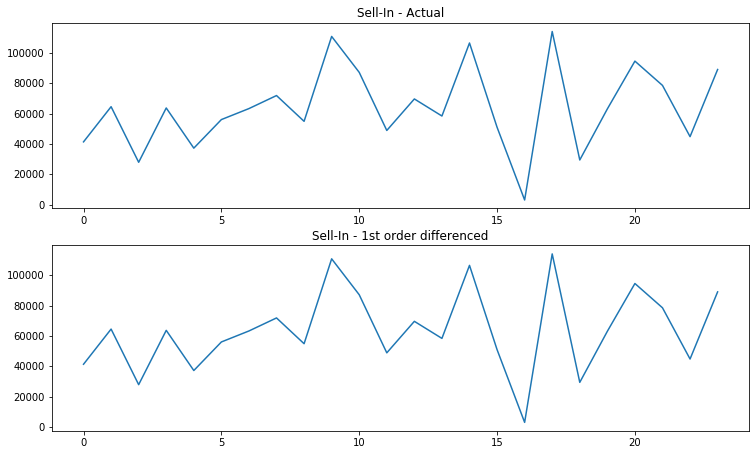

In [938]:
fig, ax = plt.subplots(2,1, figsize=(12.5,7.5))  #plotting grapgh to check stationary

df_train.reset_index()['Sell-In'].plot(ax=ax[0])
df_differenced.reset_index()['Sell-In'].plot(ax=ax[1])
ax[0].set_title('Sell-In - Actual')
ax[1].set_title('Sell-In - 1st order differenced')

In [939]:
from statsmodels.tsa.stattools import grangercausalitytests 
maxlag=4
test = 'ssr_chi2test'

df = pd.DataFrame(np.zeros((len(df_differenced.columns), len(df_differenced.columns))), columns=df_differenced.columns, index=df_differenced.columns)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(df_differenced[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in df_differenced.columns]
df.index = [var + '_y' for var in df_differenced.columns]

grangerdf = df
grangerdf

,Sell-In_x,TempSH_x
Sell-In_y,1.0000,0.0
TempSH_y,0.0146,1.0


In [940]:
alpha = 0.05                                #Co-Integration test
out = coint_johansen(df_differenced,-1,5)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d[str(1-alpha)]]
def adjust(val, length= 6): 
    return str(val).ljust(length)

# # Summary
col_name =[]
trace_value = []
cvt_value = []
indicator = []
for col, trace, cvt in zip(df_differenced.columns, traces, cvts):
    col_name.append(col)
    trace_value.append(np.round(trace, 2))
    cvt_value.append(cvt)
    indicator.append(trace> cvt)
    
d = {'Name':col_name, 'Test Stat' : trace_value, 'Critical Value (95%)': cvt_value, 'Significance': indicator} 
cj = pd.DataFrame(d)
cj[['Name', 'Test Stat', 'Critical Value (95%)', 'Significance']]

,Name,Test Stat,Critical Value (95%),Significance
0,Sell-In,14.42,12.3212,True
1,TempSH,0.08,4.1296,False


In [941]:
model = VAR(df_differenced) #initialiing VAR model
for i in range(1,12):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  23.42268477418235
BIC :  23.718900656598652
FPE :  14915610301.017015
HQIC:  23.497182238336144 

Lag Order = 2
AIC :  21.326210888903947
BIC :  21.82213927679409
FPE :  1857257963.3721783
HQIC:  21.443036704869172 

Lag Order = 3
AIC :  20.821516525337294
BIC :  21.517864817152912
FPE :  1163242909.3554163
HQIC:  20.972641930617275 

Lag Order = 4
AIC :  20.32177492312105
BIC :  21.217933969319642
FPE :  768980398.4608463
HQIC:  20.49671458377796 

Lag Order = 5
AIC :  20.694547434771657
BIC :  21.78810835801701
FPE :  1348514753.3557804
HQIC:  20.87962139155964 

Lag Order = 6
AIC :  20.132427873440022
BIC :  21.418520412623373
FPE :  1184560395.7479248
HQIC:  20.309762692867086 

Lag Order = 7
AIC :  15.198734970960706
BIC :  16.669111460471676
FPE :  29933854.361361213
HQIC:  15.344893293695225 

Lag Order = 8
AIC :  -75.79692530897293
BIC :  -74.1551742742134
FPE :  1.8753827834683773e-32
HQIC:  -75.71285418668548 

Lag Order = 9
AIC :  -77.6534004716984
BIC :

C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [942]:
model_fitted = model.fit(5) 
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Jan, 2022
Time:                     23:37:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.7881
Nobs:                     19.0000    HQIC:                   20.8796
Log likelihood:          -228.518    FPE:                1.34851e+09
AIC:                      20.6945    Det(Omega_mle):     5.40904e+08
--------------------------------------------------------------------
Results for equation Sell-In
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const         131402.835589    163142.288897            0.805           0.421
L1.Sell-In        -0.723604         0.358544           -2.018           0.044
L1.TempSH      -1240.521245      6960.643973           -0.178         

In [943]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:       
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [944]:
lag_order = model_fitted.k_ar   #getting input lag
print(lag_order) 
forecast_input = df_differenced.values[-lag_order:]  #input for mode;
fc = model_fitted.forecast(y=forecast_input, steps=nobs)  #forecast result
df_forecast = pd.DataFrame(fc, index=data1.index[-nobs:], columns=data1.columns + '_1d')  
df_results['Sell-In_forecast'] = df_forecast['Sell-In_1d'].values
forecast = df_results['Sell-In_forecast'].values
actual = df_test['Sell-In']
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
wape = (sum(abs(df_test['Sell-In']-df_results['Sell-In_forecast'])) / sum(abs(df_test['Sell-In']))) *100 #WAPE
print('Mean Absolute Percentage Error: ',mape)
print('WAPE                          :',wape)

5
Mean Absolute Percentage Error:  0.3187740605746055
WAPE                          : 28.973812077398197


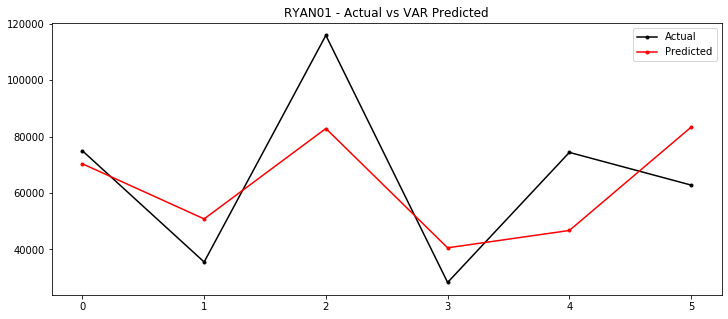

In [945]:
fig, ax = plt.subplots(figsize=(12, 5))

df_test.reset_index()['Sell-In'].plot(color='k', label='Actual',marker='.')
df_results.reset_index()['Sell-In_forecast'].plot(color='r', label='Predicted',marker='.')
ax.set_title('RYAN01 - Actual vs VAR Predicted')
ax.legend()

In [946]:
Results2 = pd.DataFrame()
Results2['Actual'] = df_test['Sell-In'].values
Results2['VAR Forecast'] = df_results['Sell-In_forecast'].values

In [947]:
Results2

,Actual,VAR Forecast
0,74985,70359.068854
1,35501,50789.486014
2,115941,82875.498611
3,28240,40534.550585
4,74397,46689.083209
5,62799,83354.263295


In [948]:
pdata = data.copy()

In [949]:
pdata['y']  = pdata['Sell-In']
pdata['ds'] = pdata.index

In [950]:
m = Prophet(seasonality_mode='additive', #initializing prophet model
            growth='linear',
           yearly_seasonality=True,
            mcmc_samples=0,
            )

In [951]:
pdata['month'] = pd.DatetimeIndex(pdata.index).month #getting month and year as a feature
pdata['year'] = pd.DatetimeIndex(pdata.index).year

In [952]:
pdata1 = pdata[['y','month','year','ds']]

In [953]:
nobs = 6 ## we use the values on the last 12 months as the test set
df_train, df_test = pdata1[0:-nobs], pdata1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(24, 4)
(6, 4)


In [954]:
cols = np.array(df_train.columns)  
modified_array = np.delete(cols, np.where(cols == 'y'))
modified_array2 = np.delete(modified_array, np.where(modified_array == 'ds'))
alldf_regressor = modified_array2

In [955]:
m.add_regressor('month', prior_scale=0.5, mode='multiplicative')  #adding month,year as regressor as we will have test data also for this feature
m.add_regressor('year', prior_scale=0.5, mode='multiplicative')

In [956]:
m.fit(df_train) #fitting model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [957]:
future2 = df_test[['ds','month','year']].reset_index() 

In [958]:
forecast = m.predict(future2) #forecast

In [959]:
result = pd.DataFrame()

In [960]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_multiplicative,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,yhat
0,2019-07-01,81021.216093,85718.304112,85962.150753,80888.877261,81151.487983,10609.107322,10609.107322,10609.107322,-0.071452,...,-0.071452,-0.071452,-0.071452,-0.1552,-0.1552,-0.1552,10609.107322,10609.107322,10609.107322,85841.187053
1,2019-08-01,83261.511501,45848.299471,47024.018571,82726.895876,83799.588615,-44824.069489,-44824.069489,-44824.069489,0.096045,...,0.096045,0.096045,0.096045,-0.1552,-0.1552,-0.1552,-44824.069489,-44824.069489,-44824.069489,46434.262043
2,2019-09-01,85501.806909,183891.119697,186598.920694,84445.733707,86588.758953,77190.444243,77190.444243,77190.444243,0.263541,...,0.263541,0.263541,0.263541,-0.1552,-0.1552,-0.1552,77190.444243,77190.444243,77190.444243,185225.511848
3,2019-10-01,87669.834724,43592.987000,48137.812103,86099.343379,89275.237314,-79618.450383,-79618.450383,-79618.450383,0.431038,...,0.431038,0.431038,0.431038,-0.1552,-0.1552,-0.1552,-79618.450383,-79618.450383,-79618.450383,45840.419891
4,2019-11-01,89910.130132,-15111.228889,-8071.801081,87781.376326,92185.051421,-155432.812193,-155432.812193,-155432.812193,0.598535,...,0.598535,0.598535,0.598535,-0.1552,-0.1552,-0.1552,-155432.812193,-155432.812193,-155432.812193,-11708.341887
5,2019-12-01,92078.157946,193073.606203,203534.337705,89112.734741,95036.033092,35697.709244,35697.709244,35697.709244,0.766032,...,0.766032,0.766032,0.766032,-0.1552,-0.1552,-0.1552,35697.709244,35697.709244,35697.709244,198310.637009


In [961]:
result['y_prophet'] = forecast['yhat'].values
result['y'] = df_test['y'].values

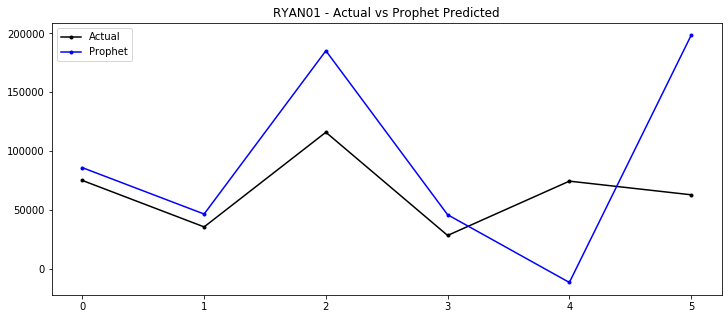

In [962]:
fig, ax = plt.subplots(figsize=(12, 5))
result['y'].plot(color='k', label='Actual',marker='.')
result['y_prophet'].plot(color='b', label='Prophet',marker='.')
ax.set_title('RYAN01 - Actual vs Prophet Predicted')
ax.legend()

In [963]:
wape = (sum(abs(result['y']-result['y_prophet'])) / sum(abs(result['y']))) *100
wape

84.28745753781538

In [964]:
Results2['Prophet Forecast'] = result['y_prophet'].values

In [965]:
Results2

,Actual,VAR Forecast,Prophet Forecast
0,74985,70359.068854,85841.187053
1,35501,50789.486014,46434.262043
2,115941,82875.498611,185225.511848
3,28240,40534.550585,45840.419891
4,74397,46689.083209,-11708.341887
5,62799,83354.263295,198310.637009


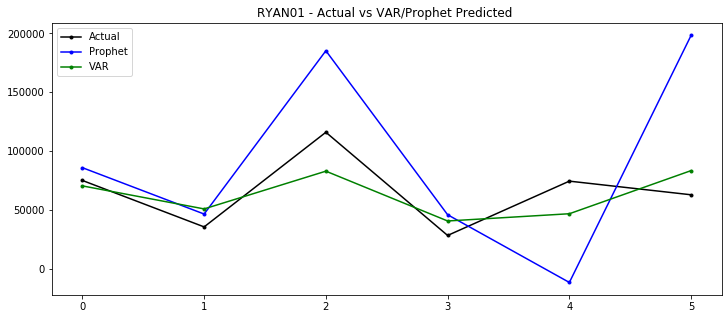

In [966]:
fig, ax = plt.subplots(figsize=(12, 5))

Results2['Actual'].plot(color='k', label='Actual',marker='.')
Results2['Prophet Forecast'].plot(color='b', label='Prophet',marker='.')
Results2['VAR Forecast'].plot(color='g', label='VAR',marker='.')
ax.set_title('RYAN01 - Actual vs VAR/Prophet Predicted ')
ax.legend()

In [967]:
Results2.index = df_test['ds']

In [968]:
Results2.to_excel('RYAN01_Reults.xlsx')

Material - 4 YCE801

In [969]:
data = Material[4].iloc[:,2:-1].copy() 

In [970]:
X = data.values 
sc = StandardScaler() 
X_std = sc.fit_transform(X) 

In [971]:
pca = PCA() 
X_pca = pca.fit(X_std)

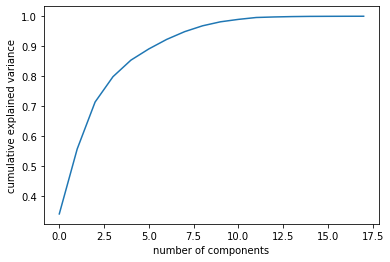

In [972]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [973]:
pca = PCA(n_components = 0.99) 
X_pca = pca.fit_transform(X_std) 
print(pca.n_components_)

12


In [974]:
num_components = 12
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std)

In [975]:
pd.DataFrame(pca.components_, columns = data.columns)

,Sell-In,Sell-Thru,Stock,Orders,EXCHUS,M2,CHNCPI,CHNImportPriceInd,CHNVisitorsKr,CHNFemaleVisitorKr,KrTourReceipt,TourDepart,TempKr,EXCHKR,TempBJ,TempSH,EUTourAccommodation,EXCHEU
0,0.064173,0.132316,-0.137303,0.010756,-0.320462,-0.388007,-0.365780,0.379487,0.085169,0.069961,-0.163263,-0.333774,-0.095146,0.307884,-0.090804,-0.102202,-0.158104,-0.361407
1,-0.017519,0.036322,0.027042,-0.070892,-0.038114,-0.074873,-0.111904,0.069860,0.154908,0.141778,-0.034902,-0.112154,0.485343,0.085039,0.482603,0.482740,0.448092,-0.027231
2,-0.311184,-0.326373,-0.381637,-0.213326,-0.095831,-0.078164,-0.137272,0.055173,-0.425945,-0.433449,-0.400162,0.066407,0.052859,-0.094440,0.054276,0.053549,0.060839,0.115044
3,0.379820,0.343511,0.286871,0.394728,-0.139360,0.075391,0.066172,0.053544,-0.447825,-0.456093,-0.083012,0.053579,0.069982,0.158883,0.080632,0.063898,0.083325,-0.035809
4,0.313512,-0.213770,-0.385383,0.657480,0.161972,-0.039580,-0.121789,-0.058657,0.165775,0.166915,-0.318636,0.058869,0.032290,-0.250619,0.027755,0.038309,-0.033610,0.039769
5,0.575742,-0.552616,-0.108941,-0.192473,-0.291746,0.069832,0.050925,0.050975,-0.067590,-0.071820,0.401378,-0.152306,0.066660,0.022601,0.075379,0.015159,-0.095407,0.071003
6,-0.470013,-0.219525,-0.021437,0.477637,-0.464220,0.074678,-0.001469,0.082085,0.017642,0.043526,0.363626,0.302465,-0.011102,0.188535,0.064696,-0.047272,0.076175,-0.026033
7,0.172704,0.486310,-0.373012,-0.169262,-0.300176,-0.035011,-0.061147,0.278443,0.065293,0.054108,0.159967,0.340232,-0.041329,-0.313158,-0.084644,0.012647,0.133691,0.346085
8,0.159613,0.069433,-0.427380,-0.127343,0.095716,0.140282,0.177899,-0.234258,0.062696,0.051181,-0.106224,0.304819,-0.037469,0.720869,-0.086305,0.037194,0.101512,-0.067280
9,-0.185087,0.235974,-0.487836,0.177993,0.290783,0.066817,0.135566,0.012935,-0.165620,-0.149840,0.452906,-0.521036,0.032009,-0.000060,0.058312,0.030156,-0.022792,-0.022160


In [976]:
n_pcs= pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = data.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['M2',
 'TempKr',
 'CHNFemaleVisitorKr',
 'CHNFemaleVisitorKr',
 'Orders',
 'Sell-In',
 'Orders',
 'Sell-Thru',
 'EXCHKR',
 'TourDepart',
 'EXCHEU',
 'EXCHEU']

In [977]:
data1 = data[['Sell-In','CHNVisitorsKr','M2','EXCHKR']]

In [978]:
nobs = 12
df_train, df_test = data1[0:-nobs], data1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(49, 4)
(12, 4)


In [979]:
def adf(data,  variable=None, signif=0.05, verbose=False): #Adfuler test to check stationary of time series
    r = adfuller(data, autolag='AIC')
    output = {'test_statistic':np.round(r[0], 4), 'pvalue':np.round(r[1], 4), 'n_lags':np.round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']    
    for key,val in r[4].items():
        print(' Critical value', key, np.round(val, 3))
    if p_value <= signif:
        print("p-Value = ", p_value, ". P value is less than critical value. Reject Null H. Series is Stationary.")
    else:
        print("p-Value = ", p_value, ".  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary")

In [980]:
for name, column in df_train.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -3.575
 Critical value 5% -2.924
 Critical value 10% -2.6
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.578
 Critical value 5% -2.925
 Critical value 10% -2.601
p-Value =  0.1156 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Critical value 1% -3.616
 Critical value 5% -2.941
 Critical value 10% -2.609
p-Value =  0.9941 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Critical value 1% -3.575
 Critical value 5% -2.924
 Critical value 10% -2.6
p-Value =  0.5163 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary




In [981]:
# 1st order differencing
df_differenced = df_train.diff().dropna()

#2nd order differencing
# df_differenced = df_differenced.diff().dropna()

In [982]:
for name, column in df_differenced.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Critical value 1% -3.593
 Critical value 5% -2.932
 Critical value 10% -2.604
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.578
 Critical value 5% -2.925
 Critical value 10% -2.601
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.61
 Critical value 5% -2.939
 Critical value 10% -2.608
p-Value =  0.0002 . P value is less than critical value. Reject Null H. Series is Stationary.


 Critical value 1% -3.578
 Critical value 5% -2.925
 Critical value 10% -2.601
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.




After applying differencing once, the ADF test shows that the variables are stationary.

Text(0.5, 1.0, 'Sell-In - 1st order differenced')

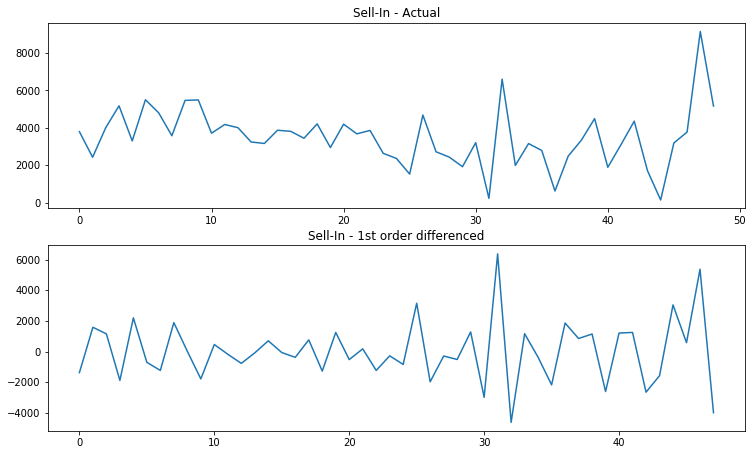

In [983]:
fig, ax = plt.subplots(2,1, figsize=(12.5,7.5))  #plotting grapgh to check stationary

df_train.reset_index()['Sell-In'].plot(ax=ax[0])
df_differenced.reset_index()['Sell-In'].plot(ax=ax[1])
ax[0].set_title('Sell-In - Actual')
ax[1].set_title('Sell-In - 1st order differenced')

In [984]:
from statsmodels.tsa.stattools import grangercausalitytests 
maxlag=4
test = 'ssr_chi2test'

df = pd.DataFrame(np.zeros((len(df_differenced.columns), len(df_differenced.columns))), columns=df_differenced.columns, index=df_differenced.columns)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(df_differenced[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in df_differenced.columns]
df.index = [var + '_y' for var in df_differenced.columns]

grangerdf = df
grangerdf

C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,Sell-In_x,CHNVisitorsKr_x,M2_x,EXCHKR_x
Sell-In_y,1.0000,0.0569,0.0482,0.6472
CHNVisitorsKr_y,0.2428,1.0000,0.1481,0.0159
M2_y,0.0962,0.3073,0.9998,0.3441
EXCHKR_y,0.5847,0.0298,0.6897,1.0000


In [985]:
alpha = 0.05                                #Co-Integration test
out = coint_johansen(df_differenced,-1,5)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d[str(1-alpha)]]
def adjust(val, length= 6): 
    return str(val).ljust(length)

# # Summary
col_name =[]
trace_value = []
cvt_value = []
indicator = []
for col, trace, cvt in zip(df_differenced.columns, traces, cvts):
    col_name.append(col)
    trace_value.append(np.round(trace, 2))
    cvt_value.append(cvt)
    indicator.append(trace> cvt)
    
d = {'Name':col_name, 'Test Stat' : trace_value, 'Critical Value (95%)': cvt_value, 'Significance': indicator} 
cj = pd.DataFrame(d)
cj[['Name', 'Test Stat', 'Critical Value (95%)', 'Significance']]

,Name,Test Stat,Critical Value (95%),Significance
0,Sell-In,49.24,40.1749,True
1,CHNVisitorsKr,15.27,24.2761,False
2,M2,5.75,12.3212,False
3,EXCHKR,2.22,4.1296,False


In [986]:
model = VAR(df_differenced) #initialiing VAR model
for i in range(1,12):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  96.32244724475575
BIC :  97.10974409654726
FPE :  6.818851141943521e+41
HQIC:  96.6187123389441 

Lag Order = 2
AIC :  96.49271729631563
BIC :  97.92382795443754
FPE :  8.224949712149772e+41
HQIC:  97.02881992613685 

Lag Order = 3
AIC :  96.87963282347567
BIC :  98.9673317005436
FPE :  1.2696943949316266e+42
HQIC:  97.6579060035489 

Lag Order = 4
AIC :  96.9970517078041
BIC :  99.75443568749596
FPE :  1.580461201014837e+42
HQIC:  98.0196226165856 

Lag Order = 5
AIC :  96.85680075782602
BIC :  100.29728470476229
FPE :  1.669647669621501e+42
HQIC:  98.12554490848486 

Lag Order = 6
AIC :  96.42985663682019
BIC :  100.5671652517806
FPE :  1.56095071840201e+42
HQIC:  97.94634387732175 

Lag Order = 7
AIC :  96.20226141342906
BIC :  101.05041652898271
FPE :  2.433925269542338e+42
HQIC:  97.96769220444051 

Lag Order = 8
AIC :  94.98118781235935
BIC :  100.55449001093535
FPE :  2.8599698275881255e+42
HQIC:  96.99631790271673 

Lag Order = 9
AIC :  56.03306576655417
BI

C:\Users\703296052\Appdata\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [987]:
model_fitted = model.fit(4) 
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Jan, 2022
Time:                     23:39:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    99.7544
Nobs:                     44.0000    HQIC:                   98.0196
Log likelihood:          -2315.67    FPE:                1.58046e+42
AIC:                      96.9971    Det(Omega_mle):     4.27834e+41
--------------------------------------------------------------------
Results for equation Sell-In
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                  341.339005       895.536109            0.381           0.703
L1.Sell-In              -0.721222         0.190873           -3.779           0.000
L1.CHNVisitorsKr         0.003782         0.00

In [988]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:       
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [989]:
lag_order = model_fitted.k_ar   #getting input lag
print(lag_order) 
forecast_input = df_differenced.values[-lag_order:]  #input for mode;
fc = model_fitted.forecast(y=forecast_input, steps=nobs)  #forecast result
df_forecast = pd.DataFrame(fc, index=data1.index[-nobs:], columns=data1.columns + '_1d')  
df_results=invert_transformation(df_train,df_forecast,second_diff=False)
forecast = df_results['Sell-In_forecast'].values
actual = df_test['Sell-In']
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
wape = (sum(abs(df_test['Sell-In']-df_results['Sell-In_forecast'])) / sum(abs(df_test['Sell-In']))) *100 #WAPE
print('Mean Absolute Percentage Error: ',mape)
print('WAPE                          :',wape)

4
Mean Absolute Percentage Error:  0.3697096590766406
WAPE                          : 37.125912642491244


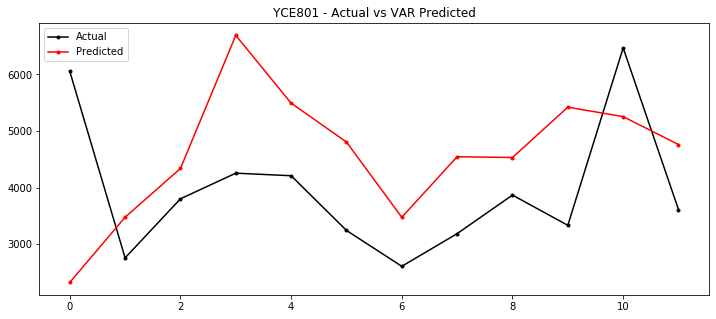

In [990]:
fig, ax = plt.subplots(figsize=(12, 5))

df_test.reset_index()['Sell-In'].plot(color='k', label='Actual',marker='.')
df_results.reset_index()['Sell-In_forecast'].plot(color='r', label='Predicted',marker='.')
ax.set_title('YCE801 - Actual vs VAR Predicted')
ax.legend()

In [991]:
Results3 = pd.DataFrame()
Results3['Actual'] = df_test['Sell-In'].values
Results3['VAR Forecast'] = df_results['Sell-In_forecast'].values

In [992]:
Results2

,Actual,VAR Forecast,Prophet Forecast
ds,,,
2019-07-01,74985,70359.068854,85841.187053
2019-08-01,35501,50789.486014,46434.262043
2019-09-01,115941,82875.498611,185225.511848
2019-10-01,28240,40534.550585,45840.419891
2019-11-01,74397,46689.083209,-11708.341887
2019-12-01,62799,83354.263295,198310.637009


In [993]:
pdata = data.copy()

In [994]:
pdata['y']  = pdata['Sell-In']
pdata['ds'] = pdata.index

In [995]:
m = Prophet(seasonality_mode='multiplicative', #initializing prophet model
            growth='linear',
           yearly_seasonality=True,
            mcmc_samples=0,
            )

In [996]:
pdata['month'] = pd.DatetimeIndex(pdata.index).month #getting month and year as a feature
pdata['year'] = pd.DatetimeIndex(pdata.index).year

In [997]:
pdata1 = pdata[['y','month','year','ds']]

In [998]:
nobs = 12 ## we use the values on the last 12 months as the test set
df_train, df_test = pdata1[0:-nobs], pdata1[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(49, 4)
(12, 4)


In [999]:
cols = np.array(df_train.columns)  
modified_array = np.delete(cols, np.where(cols == 'y'))
modified_array2 = np.delete(modified_array, np.where(modified_array == 'ds'))
alldf_regressor = modified_array2

In [1000]:
m.add_regressor('month', prior_scale=0.5, mode='multiplicative')  #adding month,year as regressor as we will have test data also for this feature
m.add_regressor('year', prior_scale=0.5, mode='multiplicative')

In [1001]:
m.fit(df_train) #fitting model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [1002]:
future2 = df_test[['ds','month','year']].reset_index() 

In [1003]:
forecast = m.predict(future2) #forecast

In [1004]:
result = pd.DataFrame()

In [1005]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,month,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-01,3615.802908,-126.724832,2888.421812,3615.802856,3615.803002,-0.442809,-0.442809,-0.442809,0.004012,...,-0.446822,-0.446822,-0.446822,-0.188215,-0.188215,-0.188215,0.0,0.0,0.0,1334.145224
1,2019-02-01,3635.361574,1027.951649,4054.695245,3635.361278,3635.361992,-0.443524,-0.443524,-0.443524,0.003297,...,-0.446822,-0.446822,-0.446822,0.113574,0.113574,0.113574,0.0,0.0,0.0,2435.871979
2,2019-03-01,3653.027465,2308.960504,5559.055760,3653.026819,3653.028223,-0.444239,-0.444239,-0.444239,0.002583,...,-0.446822,-0.446822,-0.446822,0.523389,0.523389,0.523389,0.0,0.0,0.0,3942.164437
3,2019-04-01,3672.586131,-433.935566,2829.915779,3672.584983,3672.587347,-0.444954,-0.444954,-0.444954,0.001868,...,-0.446822,-0.446822,-0.446822,-0.232597,-0.232597,-0.232597,0.0,0.0,0.0,1184.222565
4,2019-05-01,3691.513872,2132.920433,5181.859146,3691.512150,3691.515664,-0.445669,-0.445669,-0.445669,0.001153,...,-0.446822,-0.446822,-0.446822,0.436940,0.436940,0.436940,0.0,0.0,0.0,3659.291750
5,2019-06-01,3711.072538,2129.443731,5219.992943,3711.070240,3711.074991,-0.446384,-0.446384,-0.446384,0.000438,...,-0.446822,-0.446822,-0.446822,0.427205,0.427205,0.427205,0.0,0.0,0.0,3639.899213
6,2019-07-01,3730.000279,-566.055082,2505.516929,3729.997166,3730.003427,-0.447099,-0.447099,-0.447099,-0.000277,...,-0.446822,-0.446822,-0.446822,-0.291839,-0.291839,-0.291839,0.0,0.0,0.0,973.761468
7,2019-08-01,3749.558944,411.050085,3384.274162,3749.555093,3749.562936,-0.447814,-0.447814,-0.447814,-0.000992,...,-0.446822,-0.446822,-0.446822,-0.062933,-0.062933,-0.062933,0.0,0.0,0.0,1834.484408
8,2019-09-01,3769.117610,1306.363945,4466.677999,3769.112858,3769.122306,-0.448529,-0.448529,-0.448529,-0.001707,...,-0.446822,-0.446822,-0.446822,0.230709,0.230709,0.230709,0.0,0.0,0.0,2948.129957
9,2019-10-01,3788.045351,316.967020,3406.543811,3788.039714,3788.050940,-0.449244,-0.449244,-0.449244,-0.002422,...,-0.446822,-0.446822,-0.446822,-0.078835,-0.078835,-0.078835,0.0,0.0,0.0,1787.658009


In [1006]:
result['y_prophet'] = forecast['yhat'].values
result['y'] = df_test['y'].values

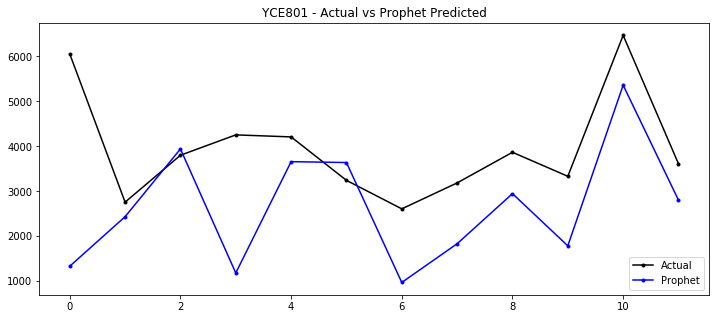

In [1007]:
fig, ax = plt.subplots(figsize=(12, 5))
result['y'].plot(color='k', label='Actual',marker='.')
result['y_prophet'].plot(color='b', label='Prophet',marker='.')
ax.set_title('YCE801 - Actual vs Prophet Predicted')
ax.legend()

In [1008]:
wape = (sum(abs(result['y']-result['y_prophet'])) / sum(abs(result['y']))) *100
wape

34.956268120870035

In [1009]:
Results3['Prophet Forecast'] = result['y_prophet'].values

In [1010]:
Results3

,Actual,VAR Forecast,Prophet Forecast
0,6054,2325.007291,1334.145224
1,2759,3477.240550,2435.871979
2,3802,4337.567897,3942.164437
3,4255,6689.210870,1184.222565
4,4210,5492.237868,3659.291750
5,3244,4805.638966,3639.899213
6,2610,3475.649576,973.761468
7,3187,4545.821375,1834.484408
8,3868,4531.705114,2948.129957
9,3334,5420.737929,1787.658009


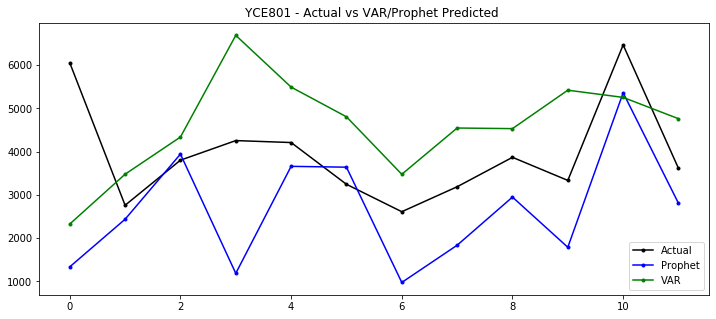

In [1011]:
fig, ax = plt.subplots(figsize=(12, 5))

Results3['Actual'].plot(color='k', label='Actual',marker='.')
Results3['Prophet Forecast'].plot(color='b', label='Prophet',marker='.')
Results3['VAR Forecast'].plot(color='g', label='VAR',marker='.')
ax.set_title('YCE801 - Actual vs VAR/Prophet Predicted ')
ax.legend()

In [1012]:
Results3.index = df_test['ds']

In [1013]:
Results3.to_excel('YCE801_Reults.xlsx')

# Thank You!